# Visual Question Answering (VQA) System

This notebook implements a VQA system using the BLIP model for answering questions about images. The system processes a dataset of images and questions, generates answers, and evaluates performance using multiple metrics (Exact Match, Token Match, WUP Score, F1 Score, and BERTScore). It also includes error analysis and visualization of results.

## Objectives
- Load and preprocess image metadata and VQA dataset.
- Run inference using the BLIP VQA model.
- Evaluate predictions with comprehensive metrics.
- Perform error analysis to identify failure cases.
- Visualize performance metrics.

## Prerequisites
- Python libraries: `torch`, `transformers`, `pandas`, `numpy`, `Pillow`, `nltk`, `sklearn`, `tqdm`, `matplotlib`, `seaborn`.
- NLTK data: `wordnet`, `punkt`, `averaged_perceptron_tagger`, `averaged_perceptron_tagger_eng`.
- Dataset: Images and a JSON file with VQA questions and answers.
- Hardware: GPU recommended for faster inference (CUDA support).

In [ ]:
import os
import json
import csv
import torch
import numpy as np
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering, BertTokenizer, BertModel
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
import nltk
from nltk.corpus import wordnet as wn
from collections import Counter
import re

# Make sure necessary NLTK packages are downloaded
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Define paths
IMAGE_BASE_DIR = r"/kaggle/input/vr-project-images/images/small"
VQA_DATA_FILE = "/kaggle/input/vr-project-json/testing.json"
INPUT_IMAGES_FILE = "/kaggle/input/vr-project-images/images/metadata/images.csv"
OUTPUT_RESULTS_FILE = "/kaggle/working/vqa_results.csv"
OUTPUT_METRICS_FILE = "/kaggle/working/vqa_metrics.json"

## Data Loading

The following functions load the image metadata and VQA dataset:
- `load_image_metadata`: Reads image metadata from a CSV file into a dictionary mapping image IDs to their properties (height, width, path).
- `load_vqa_data`: Loads the VQA dataset from a JSON file containing image IDs, questions, and ground truth answers.

In [2]:
def load_image_metadata():
    """Load image metadata from CSV into a dictionary."""
    image_map = {}
    with open(INPUT_IMAGES_FILE, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            image_map[row["image_id"]] = {
                "height": int(row["height"]),
                "width": int(row["width"]),
                "path": row["path"]
            }
    return image_map

def load_vqa_data():
    """Load the VQA dataset from JSON."""
    with open(VQA_DATA_FILE, "r", encoding="utf-8") as f:
        vqa_data = json.load(f)
    return vqa_data

## Model Setup

The VQA system uses two models:
1. **BLIP (Bootstrapped Language-Image Pre-training)**: For answering questions about images. We use the `Salesforce/blip-vqa-base` model.
2. **BERT**: For calculating BERTScore, a semantic similarity metric. We use `bert-base-uncased`.

The functions below initialize these models and move them to the appropriate device (GPU if available, else CPU):
- `setup_vqa_model`: Loads the BLIP processor and model.
- `setup_bertscore_model`: Loads the BERT tokenizer and model.

In [11]:
def setup_vqa_model():
    """Initialize the BLIP model for VQA tasks."""
    processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
    # print(model)
    # print(model.forward.__doc__)
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    return processor, model, device

def setup_bertscore_model():
    """Initialize models for BERTScore calculation."""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tokenizer, model, device

## Answer Normalization and Evaluation Metrics

To compare predicted answers with ground truth, we normalize answers and compute multiple metrics:
- **Normalization** (`normalize_answer`): Converts numbers to words, removes articles and punctuation, and standardizes whitespace.
- **Exact Match** (`exact_match`): Checks if normalized answers are identical.
- **Token Match** (`token_match`): Compares token sets for exact token overlap.
- **Wu-Palmer Similarity** (`calculate_wup_score`): Measures semantic similarity using WordNet synsets.
- **F1 Score** (`calculate_f1_score`): Computes token-based precision, recall, and F1 score.
- **BERTScore** (`calculate_bertscore`): Evaluates semantic similarity using BERT embeddings.

In [12]:
def normalize_answer(s):
    """Normalize answer for more accurate comparison."""
    # Define reversed number map (digits to words)
    number_map = {
        '0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four',
        '5': 'five', '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine', '10': 'ten'
    }
    
    # Convert digits to words
    for digit, word in number_map.items():
        s = re.sub(r'\b' + digit + r'\b', word, s.lower())
    
    # Remove articles
    s = re.sub(r'\b(a|an|the)\b', ' ', s)
    # Remove punctuation and extra whitespace
    s = re.sub(r'[^\w\s]', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def calculate_bertscore(pred, ref, tokenizer, model, device):
    """Calculate BERTScore between prediction and reference."""
    # Tokenize
    pred_tokens = tokenizer(pred, return_tensors='pt', padding=True, truncation=True).to(device)
    ref_tokens = tokenizer(ref, return_tensors='pt', padding=True, truncation=True).to(device)
    
    # Get embeddings
    with torch.no_grad():
        pred_outputs = model(**pred_tokens)
        ref_outputs = model(**ref_tokens)
    
    # Use CLS token embeddings for similarity
    pred_embedding = pred_outputs.last_hidden_state[:, 0, :]
    ref_embedding = ref_outputs.last_hidden_state[:, 0, :]
    
    # Normalize embeddings
    pred_embedding = pred_embedding / pred_embedding.norm(dim=1, keepdim=True)
    ref_embedding = ref_embedding / ref_embedding.norm(dim=1, keepdim=True)
    
    # Calculate cosine similarity
    similarity = torch.matmul(pred_embedding, ref_embedding.transpose(0, 1)).item()
    
    return similarity

def exact_match(pred, ref):
    """Check if prediction exactly matches reference after normalization."""
    return normalize_answer(pred) == normalize_answer(ref)

def token_match(pred, ref):
    """Check if the tokens in prediction match the reference."""
    pred_tokens = normalize_answer(pred).split()
    ref_tokens = normalize_answer(ref).split()
    return Counter(pred_tokens) == Counter(ref_tokens)

def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNet."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
    return tag_dict.get(tag, wn.NOUN)  # Default to NOUN if mapping not found

def calculate_wup_score(pred, ref):
    """Calculate Wu-Palmer similarity score between prediction and reference."""
    pred_tokens = normalize_answer(pred).split()
    ref_tokens = normalize_answer(ref).split()
    
    if not pred_tokens or not ref_tokens:
        return 0.0
    
    # Calculate max WUP similarity for each token pair
    max_similarities = []
    
    for p_token in pred_tokens:
        token_max_sim = 0.0
        p_synsets = wn.synsets(p_token, pos=get_wordnet_pos(p_token))
        
        if not p_synsets:  # If no synsets found, try as noun
            p_synsets = wn.synsets(p_token)
            
        if not p_synsets:  # If still no synsets, skip this token
            continue
            
        for r_token in ref_tokens:
            r_synsets = wn.synsets(r_token, pos=get_wordnet_pos(r_token))
            
            if not r_synsets:  # If no synsets found, try as noun
                r_synsets = wn.synsets(r_token)
                
            if not r_synsets:  # If still no synsets, skip this token
                continue
                
            # Calculate max similarity between all synset pairs
            token_sims = []
            for p_syn in p_synsets:
                for r_syn in r_synsets:
                    try:
                        sim = wn.wup_similarity(p_syn, r_syn)
                        if sim is not None:
                            token_sims.append(sim)
                    except:
                        continue
            
            if token_sims:
                token_max_sim = max(token_max_sim, max(token_sims))
        
        if token_max_sim > 0:  # Only add if we found at least one valid similarity
            max_similarities.append(token_max_sim)
    
    # Return average of max similarities or 0 if none found
    return sum(max_similarities) / len(max_similarities) if max_similarities else 0.0

def calculate_f1_score(pred, ref):
    """Calculate F1 score between prediction and reference tokens."""
    pred_tokens = set(normalize_answer(pred).split())
    ref_tokens = set(normalize_answer(ref).split())
    
    if not pred_tokens and not ref_tokens:
        return 1.0  # Both empty means perfect match
    
    if not pred_tokens or not ref_tokens:
        return 0.0  # One empty means no match
    
    common_tokens = pred_tokens.intersection(ref_tokens)
    
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(ref_tokens)
    
    if precision + recall == 0:
        return 0.0
    
    f1 = 2 * precision * recall / (precision + recall)
    return f1

## Running Inference

The `run_inference` function processes the VQA dataset:
- Loads image metadata and VQA data.
- Initializes BLIP and BERT models.
- For each image and question:
  - Loads the image.
  - Generates an answer using BLIP.
  - Computes evaluation metrics (Exact Match, Token Match, WUP, F1, BERTScore).
- Saves results to a CSV file.

This step is computationally intensive, especially for large datasets, and benefits from GPU acceleration.

In [13]:
def run_inference():
    """Run VQA inference on the dataset and save results with detailed metrics."""
    # Load data
    image_map = load_image_metadata()
    vqa_data = load_vqa_data()
    
    # Setup models
    vqa_processor, vqa_model, vqa_device = setup_vqa_model()
    bert_tokenizer, bert_model, bert_device = setup_bertscore_model()
    
    # Prepare results storage
    results = []
    
    # Process each item in the dataset
    for item in tqdm(vqa_data, desc="Processing VQA items"):
        image_id = item["image_id"]
        
        # Skip if image is not in the metadata
        if image_id not in image_map:
            print(f"Warning: Image ID {image_id} not found in metadata. Skipping.")
            continue
        
        # Get image path
        image_path = os.path.join(IMAGE_BASE_DIR, image_map[image_id]["path"])
        
        # Check if image exists
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found at {image_path}. Skipping.")
            continue
        
        try:
            # Load image
            image = Image.open(image_path).convert('RGB')
            
            # Process each question for this image
            for q_item in item["questions"]:
                question = q_item["question"]
                ground_truth = q_item["answer"]
                
                # Prepare inputs for the model
                inputs = vqa_processor(images=image, text=question, return_tensors="pt").to(vqa_device)
                
                # Generate answer
                with torch.no_grad():
                    generated_ids = vqa_model.generate(**inputs)
                    predicted_answer = vqa_processor.decode(generated_ids[0], skip_special_tokens=True)
                
                # Calculate metrics
                em_score = exact_match(predicted_answer, ground_truth)
                token_match_score = token_match(predicted_answer, ground_truth)
                wup_score = calculate_wup_score(predicted_answer, ground_truth)
                f1 = calculate_f1_score(predicted_answer, ground_truth)
                bertscore = calculate_bertscore(predicted_answer, ground_truth, bert_tokenizer, bert_model, bert_device)
                
                # Store result with all metrics
                results.append({
                    "image_id": image_id,
                    "question": question,
                    "ground_truth": normalize_answer(ground_truth),
                    "predicted_answer": normalize_answer(predicted_answer),
                    "exact_match": em_score,
                    "token_match": token_match_score,
                    "wup_score": wup_score,
                    "f1_score": f1,
                    "bertscore": bertscore
                })
                
        except Exception as e:
            print(f"Error processing image {image_id}: {str(e)}")
    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    results_df.to_csv(OUTPUT_RESULTS_FILE, index=False)
    
    return results_df

## Evaluating Results

The `evaluate_results` function analyzes the inference results:
- Computes overall metrics (mean Exact Match, Token Match, WUP, F1, BERTScore).
- Breaks down performance by question type (e.g., counting, color, yes/no).
- Optionally analyzes by image category (if available).
- Saves detailed metrics to a JSON file and prints a summary.

In [14]:
def evaluate_results(results_df):
    """Evaluate and print detailed metrics from the results."""
    metrics = {
        "overall": {
            "exact_match": results_df["exact_match"].mean(),
            "token_match": results_df["token_match"].mean(),
            "wup_score": results_df["wup_score"].mean(),
            "f1_score": results_df["f1_score"].mean(),
            "bertscore": results_df["bertscore"].mean()
        }
    }
    
    # Categorize questions
    results_df["question_type"] = "other"
    results_df.loc[results_df["question"].str.contains("how many|number|count", case=False), "question_type"] = "counting"
    results_df.loc[results_df["question"].str.contains("color|colour", case=False), "question_type"] = "color"
    results_df.loc[results_df["question"].str.startswith(("Is ", "Are ", "Does ", "Do ", "Can ", "Could ", "Has ", "Have ")), "question_type"] = "yes/no"
    
    # Metrics by question type
    question_types = results_df["question_type"].unique()
    metrics["by_question_type"] = {}
    for qtype in question_types:
        subset = results_df[results_df["question_type"] == qtype]
        metrics["by_question_type"][qtype] = {
            "count": len(subset),
            "exact_match": subset["exact_match"].mean(),
            "token_match": subset["token_match"].mean(),
            "wup_score": subset["wup_score"].mean(),
            "f1_score": subset["f1_score"].mean(),
            "bertscore": subset["bertscore"].mean()
        }
    
    # Metrics by category (if available)
    if "category" in results_df.columns:
        metrics["by_category"] = {}
        categories = results_df["category"].unique()
        for category in categories:
            subset = results_df[results_df["category"] == category]
            metrics["by_category"][category] = {
                "count": len(subset),
                "exact_match": subset["exact_match"].mean(),
                "token_match": subset["token_match"].mean(),
                "wup_score": subset["wup_score"].mean(),
                "f1_score": subset["f1_score"].mean(),
                "bertscore": subset["bertscore"].mean()
            }
    
    # Save metrics
    with open(OUTPUT_METRICS_FILE, 'w') as f:
        json.dump(metrics, f, indent=2)
    
    # Print summary
    print("\n===== VQA Evaluation Results =====")
    print(f"Total questions evaluated: {len(results_df)}")
    print(f"Exact match accuracy: {metrics['overall']['exact_match']:.4f}")
    print(f"Token match accuracy: {metrics['overall']['token_match']:.4f}")
    print(f"Average WUP score: {metrics['overall']['wup_score']:.4f}")
    print(f"Average F1 score: {metrics['overall']['f1_score']:.4f}")
    print(f"Average BERTScore: {metrics['overall']['bertscore']:.4f}")
    
    print("\n===== Results by Question Type =====")
    for qtype, qmetrics in metrics["by_question_type"].items():
        print(f"\n{qtype.upper()} Questions ({qmetrics['count']} questions):")
        print(f"  Exact match: {qmetrics['exact_match']:.4f}")
        print(f"  Token match: {qmetrics['token_match']:.4f}")
        print(f"  WUP score: {qmetrics['wup_score']:.4f}")
        print(f"  F1 score: {qmetrics['f1_score']:.4f}")
        print(f"  BERTScore: {qmetrics['bertscore']:.4f}")
    
    return metrics

## Error Analysis

The `run_error_analysis` function identifies and analyzes failure cases:
- Finds the worst-performing questions based on an average of all metrics.
- Analyzes error rates by question type.
- Examines the correlation between answer length and accuracy.
- Studies the distribution of F1 scores to understand performance variability.

In [15]:
def run_error_analysis(results_df):
    """Perform detailed error analysis on the results."""
    # Find the questions where the model performed worst
    results_df["avg_score"] = (
        results_df["exact_match"] + 
        results_df["token_match"] + 
        results_df["wup_score"] + 
        results_df["f1_score"] + 
        results_df["bertscore"]
    ) / 5
    
    # Sort by average score (worst first)
    worst_cases = results_df.sort_values("avg_score").head(10)
    
    print("\n===== Worst Performing Cases =====")
    for i, (_, row) in enumerate(worst_cases.iterrows()):
        print(f"\nCase {i+1}:")
        print(f"Image ID: {row['image_id']}")
        print(f"Question: {row['question']}")
        print(f"Ground Truth: {row['ground_truth']}")
        print(f"Prediction: {row['predicted_answer']}")
        print(f"Metrics: EM={row['exact_match']}, TM={row['token_match']}, WUP={row['wup_score']:.4f}, "
              f"F1={row['f1_score']:.4f}, BERTScore={row['bertscore']:.4f}")
    
    # Analyze error patterns
    error_df = results_df[~results_df["exact_match"]]
    
    # Length analysis
    results_df["gt_length"] = results_df["ground_truth"].apply(len)
    results_df["pred_length"] = results_df["predicted_answer"].apply(len)
    results_df["length_diff"] = abs(results_df["pred_length"] - results_df["gt_length"])
    
    # Group by question type and analyze errors
    error_by_qtype = error_df.groupby("question_type").size()
    total_by_qtype = results_df.groupby("question_type").size()
    error_rate_by_qtype = (error_by_qtype / total_by_qtype).fillna(0)
    
    print("\n===== Error Analysis by Question Type =====")
    for qtype, error_rate in error_rate_by_qtype.items():
        print(f"{qtype}: {error_rate:.4f} error rate ({error_by_qtype[qtype]} errors out of {total_by_qtype[qtype]} questions)")
    
    # Analyze length correlation with accuracy
    corr = results_df["gt_length"].corr(results_df["exact_match"])
    print(f"\nCorrelation between answer length and accuracy: {corr:.4f}")
    
    # Analyze F1 score distribution
    f1_ranges = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
    f1_distribution = {}
    
    for low, high in f1_ranges:
        count = ((results_df["f1_score"] >= low) & (results_df["f1_score"] < high)).sum()
        f1_distribution[f"{low}-{high}"] = count
    
    # Perfect F1 scores
    perfect_f1 = (results_df["f1_score"] == 1.0).sum()
    f1_distribution["1.0"] = perfect_f1
    
    print("\n===== F1 Score Distribution =====")
    for range_name, count in f1_distribution.items():
        percentage = count / len(results_df) * 100
        print(f"F1 Score {range_name}: {count} questions ({percentage:.2f}%)")
    
    # Return error analysis data
    return {
        "worst_cases": worst_cases,
        "error_by_qtype": error_by_qtype,
        "error_rate_by_qtype": error_rate_by_qtype,
        "length_correlation": corr,
        "f1_distribution": f1_distribution
    }

## Visualizing Metrics

The `visualize_metrics` function creates visualizations to understand model performance:
- Histograms of F1, WUP, and BERTScore distributions.
- Count plot of Exact Match results.
- Boxplots of metrics by question type.
- Saves plots as PNG files (`metric_distributions.png` and `metrics_by_question_type.png`).

**Note**: Requires `matplotlib` and `seaborn`. Install if not available.

2025-05-14 06:44:00.432404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747205040.664477      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747205040.726744      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_da

Starting VQA inference and evaluation process...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing VQA items: 100%|██████████| 1774/1774 [08:16<00:00,  3.58it/s]



===== VQA Evaluation Results =====
Total questions evaluated: 4848
Exact match accuracy: 0.5210
Token match accuracy: 0.5210
Average WUP score: 0.7435
Average F1 score: 0.5291
Average BERTScore: 0.9569

===== Results by Question Type =====

COLOR Questions (1577 questions):
  Exact match: 0.6620
  Token match: 0.6620
  WUP score: 0.8262
  F1 score: 0.6716
  BERTScore: 0.9782

YES/NO Questions (1195 questions):
  Exact match: 0.6402
  Token match: 0.6402
  WUP score: 0.7564
  F1 score: 0.6407
  BERTScore: 0.9764

OTHER Questions (1441 questions):
  Exact match: 0.3324
  Token match: 0.3324
  WUP score: 0.5750
  F1 score: 0.3487
  BERTScore: 0.9322

COUNTING Questions (635 questions):
  Exact match: 0.3748
  Token match: 0.3748
  WUP score: 0.8958
  F1 score: 0.3748
  BERTScore: 0.9233

===== Worst Performing Cases =====

Case 1:
Image ID: 61Rh0XkfrEL
Question: What type of oil is used for hair conditioning?
Ground Truth: argan
Prediction: shampoo
Metrics: EM=False, TM=False, WUP=0.0000

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Visualization images saved as 'metric_distributions.png' and 'metrics_by_question_type.png'

Results saved to /kaggle/working/vqa_results.csv
Detailed metrics saved to /kaggle/working/vqa_metrics.json


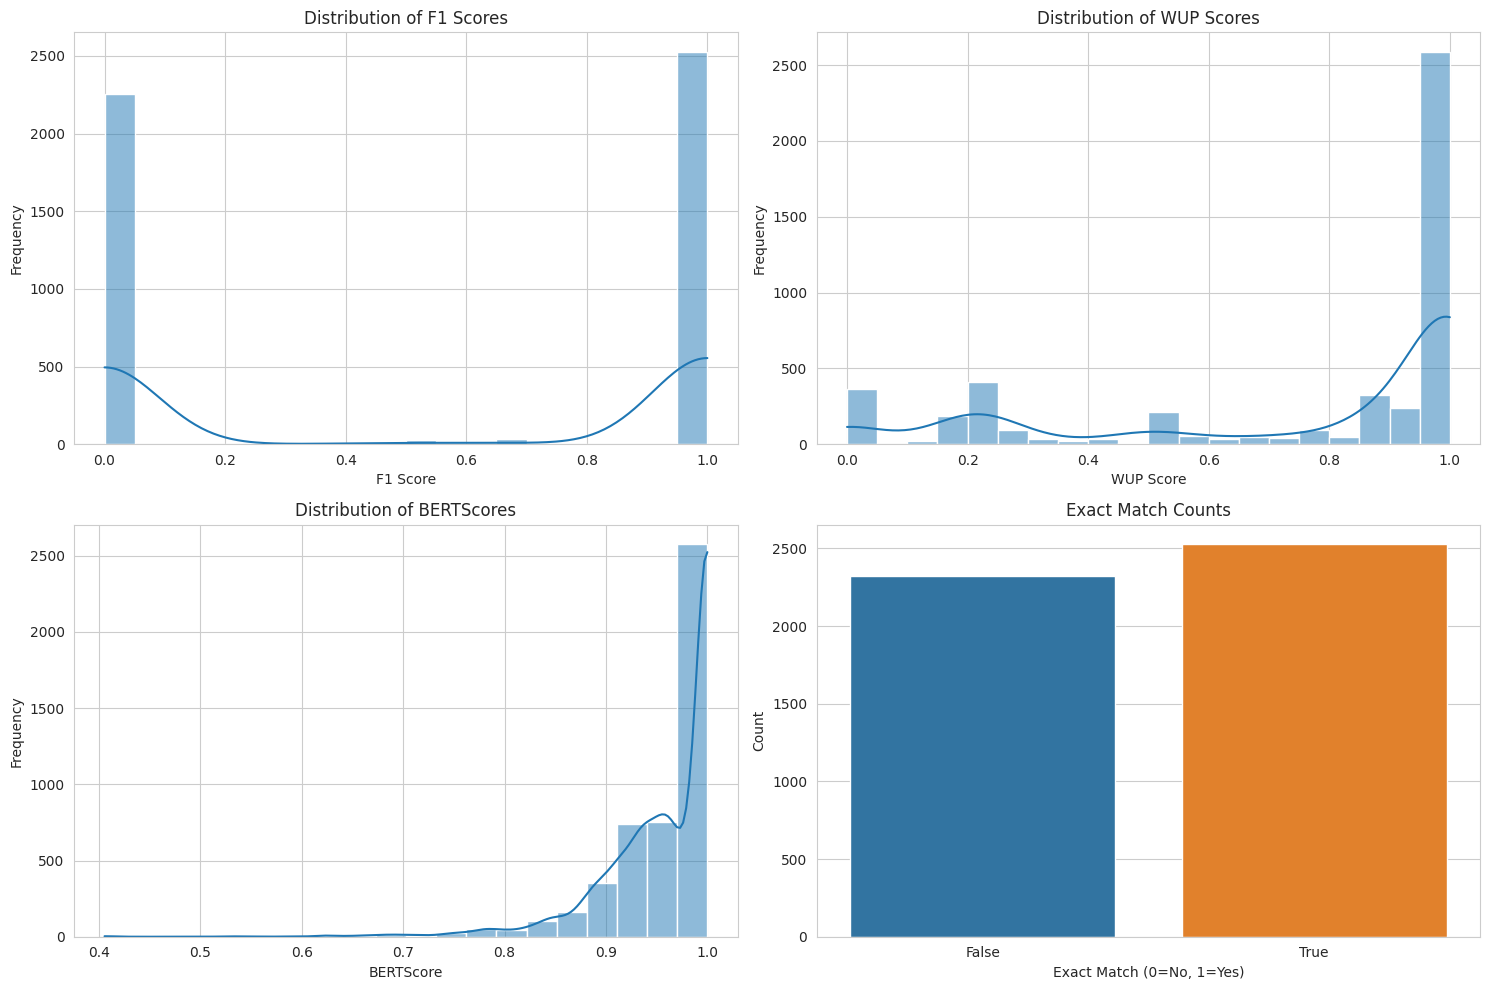

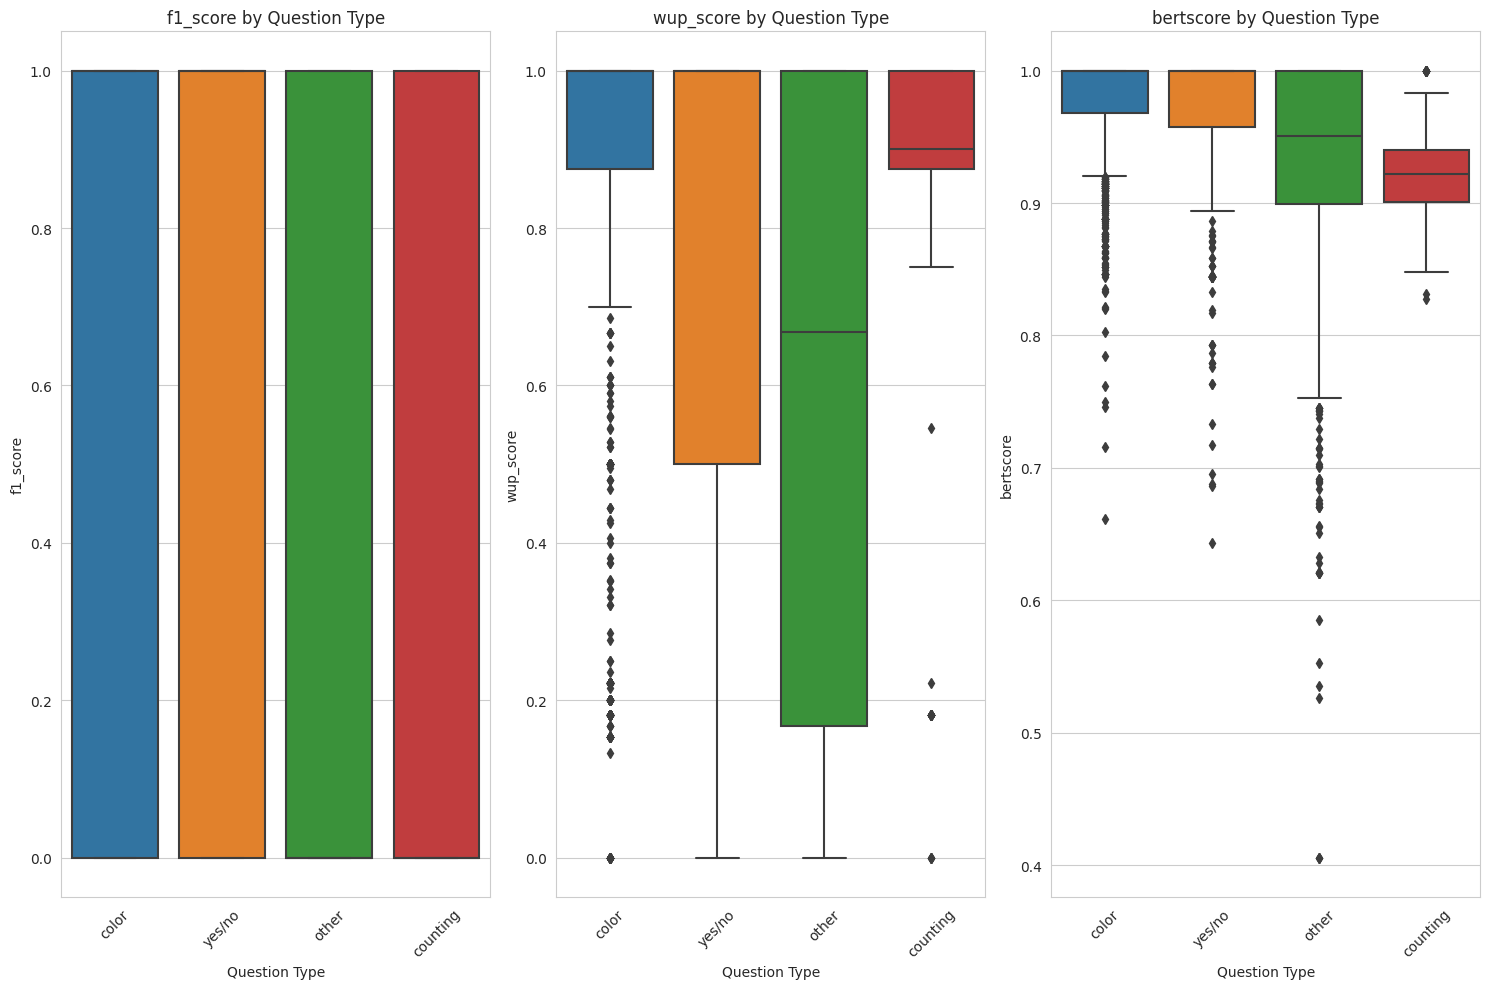

In [ ]:

def visualize_metrics(results_df):
    """Create visualizations of the evaluation metrics."""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Set style
        sns.set_style("whitegrid")
        
        # Create figure for metric distributions
        plt.figure(figsize=(15, 10))
        
        # Distribution of metrics
        plt.subplot(2, 2, 1)
        sns.histplot(data=results_df, x="f1_score", bins=20, kde=True)
        plt.title("Distribution of F1 Scores")
        plt.xlabel("F1 Score")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 2)
        sns.histplot(data=results_df, x="wup_score", bins=20, kde=True)
        plt.title("Distribution of WUP Scores")
        plt.xlabel("WUP Score")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 3)
        sns.histplot(data=results_df, x="bertscore", bins=20, kde=True)
        plt.title("Distribution of BERTScores")
        plt.xlabel("BERTScore")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 4)
        sns.countplot(data=results_df, x="exact_match")
        plt.title("Exact Match Counts")
        plt.xlabel("Exact Match (0=No, 1=Yes)")
        plt.ylabel("Count")
        
        plt.tight_layout()
        plt.savefig("metric_distributions.png")
        
        # Boxplot of metrics by question type
        plt.figure(figsize=(15, 10))
        metrics = ["f1_score", "wup_score", "bertscore"]
        
        for i, metric in enumerate(metrics):
            plt.subplot(1, 3, i+1)
            sns.boxplot(data=results_df, x="question_type", y=metric)
            plt.title(f"{metric} by Question Type")
            plt.xlabel("Question Type")
            plt.ylabel(metric)
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig("metrics_by_question_type.png")
        
        print("\nVisualization images saved as 'metric_distributions.png' and 'metrics_by_question_type.png'")
        
    except ImportError:
        print("\nNote: matplotlib and seaborn are required for visualization. Install with: pip install matplotlib seaborn")

if __name__ == "__main__":
    print("Starting VQA inference and evaluation process...")
    results = run_inference()
    metrics = evaluate_results(results)
    error_analysis = run_error_analysis(results)
    visualize_metrics(results)  # Optional visualization
    print(f"\nResults saved to {OUTPUT_RESULTS_FILE}")
    print(f"Detailed metrics saved to {OUTPUT_METRICS_FILE}")